# AlexNet

In [47]:
import torch
import torch.nn as nn

IMAGE_SIZE = 227

class AlexNet(nn.Module):
  def __init__(self, num_classes=10):
    super(AlexNet, self).__init__()

    # 특징 추출
    self.features = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
        nn.BatchNorm2d(96),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(384),
        nn.ReLU(inplace=True),

        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(384),
        nn.ReLU(inplace=True),

        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )

    dummy_input = torch.zeros(1, 3, IMAGE_SIZE, IMAGE_SIZE)
    dummy_output = self.features(dummy_input)
    flatten_dim = dummy_output.view(1, -1).shape[1]

    # 분류
    self.classifier = nn.Sequential(
        nn.Flatten(),

        nn.Linear(flatten_dim, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),

        nn.Linear(4096, num_classes)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x

In [48]:
from torch.utils.data import Dataset
import numpy as np
import cv2
from sklearn.utils import shuffle

BATCH_SIZE = 64

class Cifar10Dataset(Dataset):
  def __init__(self, images, labels=None, image_size=IMAGE_SIZE, augmentor=None, preprocess_function=None, shuffle_data=False):
    self.images = images
    self.labels = labels
    self.image_size = image_size
    self.augmentor = augmentor
    self.preprocess_function = preprocess_function

    if shuffle_data and labels is not None:
      self.images, self.labels = shuffle(self.images, self.labels)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx] if self.labels is not None else None

    if self.augmentor is not None:
      image = self.augmentor(image)['image']

    image = cv2.resize(image, (self.image_size, self.image_size))

    if self.preprocess_function is not None:
      image = self.preprocess_function(image)

    # 채널 순서 변경 (h, w, c) -> (c, h, w)
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)

    if label is not None:
      return image, label
    else:
      return image

In [49]:
from torchvision.datasets import CIFAR10
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn.functional as F

train_data = CIFAR10(root='./', train=True, download=True)
test_data = CIFAR10(root='./', train=False, download=True)

train_images = np.array(train_data.data)
train_labels = np.array(train_data.targets).reshape(-1, 1)
test_images = np.array(test_data.data)
test_labels = np.array(test_data.targets).reshape(-1, 1)

tr_images, val_images, tr_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=0)

tr_labels = F.one_hot(torch.tensor(tr_labels.squeeze()), num_classes=10).numpy()
val_labels = F.one_hot(torch.tensor(val_labels.squeeze()), num_classes=10).numpy()
test_labels = F.one_hot(torch.tensor(test_labels.squeeze()), num_classes=10).numpy()

In [50]:
from torch.utils.data import DataLoader

def pre_func(image):
  return image / 255.0

tr_dataset = Cifar10Dataset(tr_images, tr_labels, preprocess_function=pre_func, shuffle_data=True)
val_dataset = Cifar10Dataset(val_images, val_labels, preprocess_function=pre_func)
test_dataset = Cifar10Dataset(test_images, test_labels, preprocess_function=pre_func)

tr_loader = DataLoader(tr_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [51]:
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import pandas as pd

model = AlexNet(num_classes=10)
model = model.cuda() if torch.cuda.is_available() else model
device = next(model.parameters()).device

criterion = nn.CrossEntropyLoss()
optim = Adam(model.parameters())
scheduler = ReduceLROnPlateau(optim, mode='min', patience=5, factor=0.5, verbose=True)

In [52]:
class EarlyStopping:
  def __init__(self, patience=10, verbose=False):
    self.patience = patience
    self.verbose = verbose
    self.counter = 0
    self.best_loss = float('inf')
    self.best_model = None
    self.early_stop = False

  def __call__(self, val_loss, model):
    if val_loss < self.best_loss:
      self.best_loss = val_loss
      self.best_model = model.state_dict()
      self.counter = 0
    else:
      self.counter += 1
      if self.verbose:
        print(f"EarylStopping counter: {self.counter}/{self.patience}")
      if self.counter >= self.patience:
        self.early_stop = True

early_stopping = EarlyStopping(patience=10, verbose=True)

In [53]:
EPOCHS = 30
history = {
    'loss': [],
    'val_loss': [],
    'val_accuracy': [],
    'accuracy': []
}

for epoch in range(EPOCHS):
  model.train()
  total_loss = 0
  correct = 0
  total = 0

  for images, labels in tr_loader:
    images, labels = images.to(device), labels.to(device)
    labels = torch.argmax(labels, dim=1)

    outputs = model(images)
    loss = criterion(outputs, labels)

    optim.zero_grad()
    loss.backward()
    optim.step()

    total_loss += loss.item()
    _, preds = torch.max(outputs, 1)
    correct += (preds == labels).sum().item()
    total += labels.size(0)

  avg_loss = total_loss / len(tr_loader)
  train_acc = correct / total

  model.eval()
  val_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      labels = torch.argmax(labels, dim=1)

      outputs = model(images)
      loss = criterion(outputs, labels)

      val_loss += loss.item()
      _, preds = torch.max(outputs, 1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)

  avg_val_loss = val_loss / len(val_loader)
  val_acc = correct / total

  history["loss"].append(avg_loss)
  history["val_loss"].append(avg_val_loss)
  history["accuracy"].append(train_acc)
  history["val_accuracy"].append(val_acc)

  print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f}, Acc: {train_acc:.4f}, ValLoss: {avg_val_loss:.4f}, ValAcc: {val_acc:.4f}")

  scheduler.step(avg_val_loss)
  early_stopping(avg_val_loss, model)
  if early_stopping.early_stop:
    print("조기 종료!")
    break


Epoch 1/30 | Loss: 2.1366, Acc: 0.2470, ValLoss: 1.8421, ValAcc: 0.3008
Epoch 2/30 | Loss: 1.7718, Acc: 0.3193, ValLoss: 1.7562, ValAcc: 0.3568
Epoch 3/30 | Loss: 1.5950, Acc: 0.3955, ValLoss: 1.6129, ValAcc: 0.4054
Epoch 4/30 | Loss: 1.4100, Acc: 0.4817, ValLoss: 1.2873, ValAcc: 0.5462
Epoch 5/30 | Loss: 1.2547, Acc: 0.5550, ValLoss: 1.2221, ValAcc: 0.5790
Epoch 6/30 | Loss: 1.1020, Acc: 0.6149, ValLoss: 1.0378, ValAcc: 0.6445
Epoch 7/30 | Loss: 0.9839, Acc: 0.6590, ValLoss: 1.0064, ValAcc: 0.6676
Epoch 8/30 | Loss: 0.8763, Acc: 0.6975, ValLoss: 0.8257, ValAcc: 0.7256
Epoch 9/30 | Loss: 0.7726, Acc: 0.7342, ValLoss: 0.7823, ValAcc: 0.7430
Epoch 10/30 | Loss: 0.6876, Acc: 0.7639, ValLoss: 0.8349, ValAcc: 0.7138
EarylStopping counter: 1/10
Epoch 11/30 | Loss: 0.6129, Acc: 0.7932, ValLoss: 0.6540, ValAcc: 0.7841
Epoch 12/30 | Loss: 0.5542, Acc: 0.8108, ValLoss: 0.6651, ValAcc: 0.7786
EarylStopping counter: 1/10
Epoch 13/30 | Loss: 0.4862, Acc: 0.8346, ValLoss: 0.6216, ValAcc: 0.7923
Epoc

In [54]:
model.load_state_dict(early_stopping.best_model)

<All keys matched successfully>

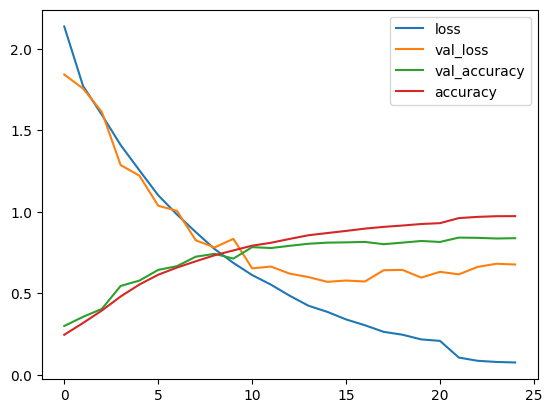

In [55]:
df = pd.DataFrame(history)
df.plot()
plt.show()

In [56]:
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels = torch.argmax(labels, dim=1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct / total
print(f'loss: {avg_test_loss:.4f}, accuracy: {test_accuracy:.4f}')

loss: 0.7121, accuracy: 0.8349
